In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import os
# print(os.listdir("../input"))

# pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
%matplotlib inline

In [2]:
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv')

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# From EDA obvious outliers
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)

outliers = [30, 88, 462, 631, 1322]
train = train.drop(train.index[outliers])


print (train.columns)
print(test.columns)
print(train.shape,test.shape)

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo


 mu = 181268.63 and sigma = 79370.09


 mu = 12.03 and sigma = 0.40



Text(0.5, 0.98, 'After transformation')

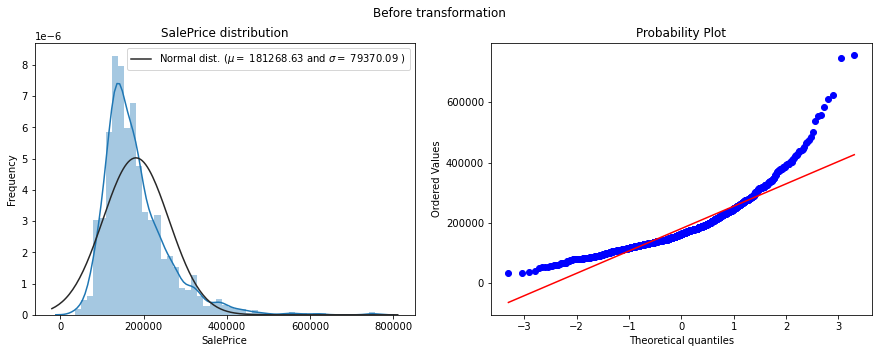

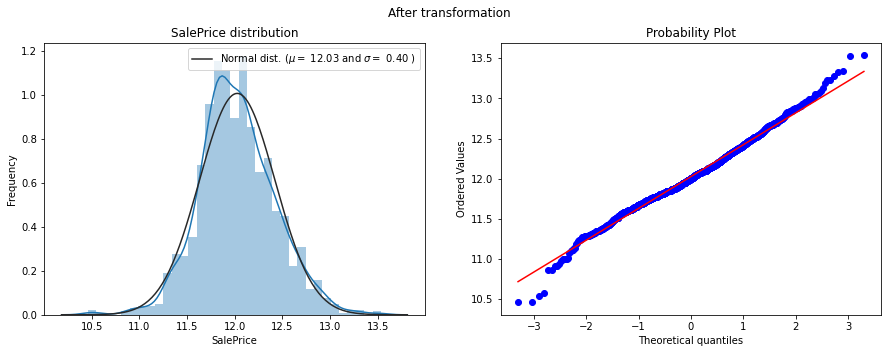

In [3]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

# Plot histogram and probability
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.subplot(1,2,2)
res = stats.probplot(train['SalePrice'], plot=plt)
plt.suptitle('Before transformation')

# Apply transformation
train.SalePrice = np.log1p(train.SalePrice )
# New prediction
y_train = train.SalePrice.values
y_train_orig = train.SalePrice


# Plot histogram and probability after transformation
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.subplot(1,2,2)
res = stats.probplot(train['SalePrice'], plot=plt)
plt.suptitle('After transformation')

In [4]:
data_features = pd.concat((train, test)).reset_index(drop=True)
print(data_features.shape)

(2912, 80)


In [5]:
data_features_na = data_features.isnull().sum()
data_features_na = data_features_na[data_features_na>0]
data_features_na.sort_values(ascending=False)


PoolQC          2903
MiscFeature     2807
Alley           2715
Fence           2344
SalePrice       1459
FireplaceQu     1418
LotFrontage      486
GarageYrBlt      158
GarageFinish     158
GarageQual       158
GarageCond       158
GarageType       156
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
BsmtFinSF2         1
BsmtUnfSF          1
BsmtFinSF1         1
TotalBsmtSF        1
SaleType           1
KitchenQual        1
Exterior2nd        1
Exterior1st        1
GarageCars         1
GarageArea         1
Electrical         1
dtype: int64

In [6]:
total = data_features.isnull().sum().sort_values(ascending=False)
percent = (data_features.isnull().sum()/data_features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,2903,0.996909
MiscFeature,2807,0.963942
Alley,2715,0.932349
Fence,2344,0.804945
SalePrice,1459,0.501030
FireplaceQu,1418,0.486951
LotFrontage,486,0.166896
GarageCond,158,0.054258
GarageYrBlt,158,0.054258
GarageQual,158,0.054258


In [7]:
str_vars = ['MSSubClass','YrSold','MoSold']
for var in str_vars:
    data_features[var] = data_features[var].apply(str)

In [8]:
common_vars = ['Exterior1st','Exterior2nd','SaleType','Electrical','KitchenQual']
for var in common_vars:
    data_features[var] = data_features[var].fillna(data_features[var].mode()[0])
    
# 'RL' is by far the most common value. So we can fill in missing values with 'RL'
data_features['MSZoning'] = data_features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))


In [9]:
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual',
            'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',"PoolQC"
           ,'Alley','Fence','MiscFeature','FireplaceQu','MasVnrType','Utilities']:
    data_features[col] = data_features[col].fillna('None')

In [10]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','MasVnrArea','BsmtFinSF1','BsmtFinSF2'
           ,'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BsmtUnfSF','TotalBsmtSF'):
    data_features[col] = data_features[col].fillna(0)

# group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
data_features['LotFrontage'] = data_features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
print('Features size:', data_features.shape)

Features size: (2912, 80)


In [11]:
data_features['Functional'] = data_features['Functional'].fillna('Typ')
#missing data
total = data_features.isnull().sum().sort_values(ascending=False)
percent = (data_features.isnull().sum()/data_features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
SalePrice,1459,0.50103
SaleCondition,0,0.00000
RoofMatl,0,0.00000
Exterior1st,0,0.00000
Exterior2nd,0,0.00000
MasVnrType,0,0.00000
MasVnrArea,0,0.00000
ExterQual,0,0.00000
ExterCond,0,0.00000
Foundation,0,0.00000


In [12]:
categorical_features = data_features.select_dtypes(include=['object']).columns
print(categorical_features)
numerical_features = data_features.select_dtypes(exclude = ["object"]).columns
print(numerical_features)

print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
feat_num = data_features[numerical_features]
feat_cat = data_features[categorical_features]

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition'],
      dtype='object')
Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'B

In [13]:
from scipy.stats import skew 
skewness = feat_num.apply(lambda x: skew(x))
skewness.sort_values(ascending=False)

skewness = skewness[abs(skewness) > 0.5]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
print("Mean skewnees: {}".format(np.mean(skewness)))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    feat_num[feat] = boxcox1p(feat_num[feat], boxcox_normmax(feat_num[feat] + 1))
    data_features[feat] = boxcox1p(data_features[feat], boxcox_normmax(data_features[feat] + 1))
    
    
from scipy.stats import skew 
skewness.sort_values(ascending=False)

There are 27 skewed numerical features to Box Cox transform
Mean skewnees: 4.055477203766242


MiscVal          21.920854
PoolArea         17.673354
LotArea          13.099125
LowQualFinSF     12.391544
3SsnPorch        11.362112
KitchenAbvGr      4.296287
BsmtFinSF2        4.145924
EnclosedPorch     4.029556
ScreenPorch       3.941117
BsmtHalfBath      3.925998
MasVnrArea        2.624575
OpenPorchSF       2.527454
WoodDeckSF        1.844011
1stFlrSF          1.259015
LotFrontage       1.105058
GrLivArea         1.068478
BsmtFinSF1        0.980559
BsmtUnfSF         0.919505
2ndFlrSF          0.860245
TotRmsAbvGrd      0.747869
Fireplaces        0.726054
HalfBath          0.693943
TotalBsmtSF       0.672246
BsmtFullBath      0.619682
OverallCond       0.578748
YearBuilt        -0.600202
GarageYrBlt      -3.915227
dtype: float64

In [14]:
skewness = feat_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]

print("There are {} skewed numerical features after Box Cox transform".format(skewness.shape[0]))
print("Mean skewnees: {}".format(np.mean(skewness)))
skewness.sort_values(ascending=False)

There are 17 skewed numerical features after Box Cox transform
Mean skewnees: 3.5048422785184727


PoolArea         15.581589
3SsnPorch         8.854291
LowQualFinSF      8.598260
MiscVal           5.233200
BsmtHalfBath      3.775618
KitchenAbvGr      3.774434
ScreenPorch       3.149430
BsmtFinSF2        2.580032
EnclosedPorch     2.156781
MasVnrArea        0.977673
2ndFlrSF          0.894364
WoodDeckSF        0.784470
HalfBath          0.730155
GarageYrBlt       0.703540
OpenPorchSF       0.620616
BsmtFullBath      0.614203
Fireplaces        0.553661
dtype: float64

In [15]:
data_features['TotalSF']=data_features['TotalBsmtSF'] + data_features['1stFlrSF'] + data_features['2ndFlrSF']
#  Adding total bathrooms feature
data_features['Total_Bathrooms'] = (data_features['FullBath'] + (0.5 * data_features['HalfBath']) +
                               data_features['BsmtFullBath'] + (0.5 * data_features['BsmtHalfBath']))
#  Adding total porch sqfootage feature
data_features['Total_porch_sf'] = (data_features['OpenPorchSF'] + data_features['3SsnPorch'] +
                              data_features['EnclosedPorch'] + data_features['ScreenPorch'] +
                              data_features['WoodDeckSF'])

In [16]:
data_features['haspool'] = data_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
data_features['hasgarage'] = data_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
data_features['hasbsmt'] = data_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
data_features['hasfireplace'] = data_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


# Not normaly distributed can not be normalised and has no central tendecy
data_features = data_features.drop(['MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'BsmtFinSF1','2ndFlrSF'], axis=1)
# data_features = data_features.drop(['MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'BsmtFinSF1','2ndFlrSF',
#                          'PoolArea','3SsnPorch','LowQualFinSF','MiscVal','BsmtHalfBath','ScreenPorch',
#                          'ScreenPorch','KitchenAbvGr','BsmtFinSF2','EnclosedPorch','LotFrontage'
#                          ,'BsmtUnfSF','GarageYrBlt'], axis=1)

print('data_features size:', data_features.shape)

data_features size: (2912, 82)


In [17]:
train = data_features.iloc[:len(y_train), :]
test = data_features.iloc[len(y_train):, :]
print(['Train data shpe: ',train.shape,'Prediction on (Sales price) shape: ', y_train.shape,'Test shape: ', test.shape])

['Train data shpe: ', (1453, 82), 'Prediction on (Sales price) shape: ', (1453,), 'Test shape: ', (1459, 82)]


In [18]:

y_train = train['SalePrice']

In [19]:
y = y_train

data_features = data_features.drop("SalePrice", axis = 1)
final_features = pd.get_dummies(data_features)

print(final_features.shape)
X = final_features.iloc[:len(y), :]
X_test = final_features.iloc[len(y):, :]
X.shape, y_train.shape, X_test.shape


print(X.shape,y_train.shape,X_test.shape)

(2912, 334)
(1453, 334) (1453,) (1459, 334)


In [20]:
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.95:
        overfit.append(i)

overfit = list(overfit)
overfit.append('MSZoning_C (all)')

X = X.drop(overfit, axis=1).copy()
X_test = X_test.drop(overfit, axis=1).copy()

print(X.shape,y_train.shape,X_test.shape)

(1453, 331) (1453,) (1459, 331)


In [21]:
from datetime import datetime
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error , make_scorer
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [22]:
kfolds = KFold(n_splits=18, shuffle=True, random_state=42)

# model scoring and validation function
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y,scoring="neg_mean_squared_error",cv=kfolds))
    return (rmse)

# rmsle scoring function
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [23]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4, #was 3
                                       learning_rate=0.01, 
                                       n_estimators=9000, #8000
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2, # 'was 0.2'
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

# xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
#                                      max_depth=3, min_child_weight=0,
#                                      gamma=0, subsample=0.7,
#                                      colsample_bytree=0.7,
#                                      objective='reg:linear', nthread=-1,
#                                      scale_pos_weight=1, seed=27,
#                                      reg_alpha=0.00006)



# setup models hyperparameters using a pipline
# The purpose of the pipeline is to assemble several steps that can be cross-validated together, while setting different parameters.
# This is a range of values that the model considers each time in runs a CV
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]




# Kernel Ridge Regression : made robust to outliers
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))

# LASSO Regression : made robust to outliers
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, 
                    alphas=alphas2,random_state=42, cv=kfolds))

# Elastic Net Regression : made robust to outliers
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, 
                         alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))


stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, lightgbm),
                                meta_regressor=elasticnet,
                                use_features_in_secondary=True)


svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# store models, scores and prediction values 
models = {'Ridge': ridge,
          'Lasso': lasso, 
          'ElasticNet': elasticnet,
          'lightgbm': lightgbm,
          'Svd': svr}
#           'xgboost': xgboost}
predictions = {}
scores = {}

In [25]:
for name, model in models.items():
    model.fit(X, y)
    predictions[name] = np.expm1(model.predict(X))
    score = cv_rmse(model, X=X)
    scores[name] = (score.mean(), score.std())

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 w

In [26]:
# get the performance of each model on training data(validation set)
print('---- Score with CV_RMSLE-----')
score = cv_rmse(ridge)
print("Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(elasticnet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(lightgbm)
print("lightgbm score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['svr'] = (score.mean(), score.std())

# score = cv_rmse(xgboost)
# print("xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


#Fit the training data X, y
print('----START Fit----',datetime.now())
print('Elasticnet')
elastic_model = elasticnet.fit(X, y)
print('Lasso')
lasso_model = lasso.fit(X, y)
print('Ridge')
ridge_model = ridge.fit(X, y)
print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)
print('Svr')
svr_model_full_data = svr.fit(X, y)

# print('xgboost')
# xgb_model_full_data = xgboost.fit(X, y)


print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

---- Score with CV_RMSLE-----
Ridge score: 0.1017 (0.0164)

Lasso score: 0.1016 (0.0176)

ElasticNet score: 0.1016 (0.0176)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsa

In [27]:
def blend_models_predict(X):
    return ((0.16  * elastic_model.predict(X)) + \
            (0.16 * lasso_model.predict(X)) + \
            (0.11 * ridge_model.predict(X)) + \
            (0.2 * lgb_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
#             (0.1 * xgb_model_full_data.predict(X)) + \
            (0.27 * stack_gen_model.predict(np.array(X))))

In [28]:
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data:
0.07991129394837912


In [29]:
print('Predict submission')
submission = pd.read_csv("submit/sample_submission.csv")
submission.iloc[:,1] = (np.expm1(blend_models_predict(X_test)))

Predict submission
